In [62]:
from xml.sax.handler import feature_namespace_prefixes

import learn
from babel.messages.frontend import SetupError



In [63]:
import iris
import pandas as pd

host = "localhost"
# this is the superserver port
port = 32782
namespace = "FHIRSERVER"
user = "_SYSTEM"
password = "SYS"

conn = iris.connect(
    hostname=host,
    port=port,
    namespace=namespace,
    username=user,
    password=password
)

# create a cursor
cursor = conn.cursor()
cursor

The likelyhood of getting diabetes is altered by a number of factors including:

- Age
- Ethnicity
- Family History
- Weight
- Physical Inactivity
- Genetics
- Other Conditions: High blood pressure, high cholesterol, and heart disease increase the risk

To explore this data I will be using synthetic patients records from [Synthea](https://synthetichealth.github.io/synthea/) using a community version of a FHIR enabled Data Platform from Intersystems called IRIS [Intersystems Open Exchange - iris-fhir-template](https://openexchange.intersystems.com/package/iris-fhir-template).
These examples are based on US population demographics and will also use a mix of LOINC and SNOMED coding, so codes used are likely to differ from UK based systems which predominantly use SNOMED CT UK Edition.

162864005 	Body mass index 30+ - obesity
408512008   Body mass index 40+ - severely obese

In [64]:


sql = """
      select patient._id, patient.KEY, DATEDIFF('year',birthdate,$HOROLOG) as AGE,
             gender,
             case gender
                 when 'male' then 1
                 when 'female' then 2
                 when 'other' then 0
                 else 9
                 end as genderUK,
             IFNULL(diabetes._id,0,1) as TYPE2DIABETES,
             IFNULL(hypertension._id,0,1) as HYPERTENSION,
             IFNULL(obese._id,0,1) as OBESE,
             IFNULL(veryobese._id,0,1) as VERY_OBESE,
             IFNULL(diabetes._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(diabetes.onsetDateStart,'YYYY-MM-DD'))) as TYPE2DIABETES_AGE,
             IFNULL(hypertension._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(hypertension.onsetDateStart,'YYYY-MM-DD'))) as HYPERTENSION_AGE,
             IFNULL(obese._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(obese.onsetDateStart,'YYYY-MM-DD'))) as OBESE_AGE,
             IFNULL(veryobese._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(veryobese.onsetDateStart,'YYYY-MM-DD'))) as VERY_OBESE_AGE
      from HSFHIR_X0001_S.Patient patient
               left outer join HSFHIR_X0001_S.Condition diabetes on patient.Key = diabetes.patient and diabetes.code [ '44054006'
               left outer join HSFHIR_X0001_S.Condition hypertension on patient.Key = hypertension.patient and hypertension.code [ '59621000'
               left outer join HSFHIR_X0001_S.Condition obese on patient.Key = obese.patient and obese.code [ '162864005'
               left outer join HSFHIR_X0001_S.Condition veryobese on patient.Key = veryobese.patient and veryobese.code [ '408512008'
      """

cursor.execute(sql)
data = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
df = pd.DataFrame(data, columns=column_names)
pd.set_option('future.no_silent_downcasting', True)
df

,_id,Key,AGE,gender,genderUK,TYPE2DIABETES,HYPERTENSION,OBESE,VERY_OBESE,TYPE2DIABETES_AGE,HYPERTENSION_AGE,OBESE_AGE,VERY_OBESE_AGE
0,4,Patient/4,50,male,1,0,1,1,0,NaN,18.0,40.0,NaN
1,3,Patient/3,16,female,2,0,0,0,0,NaN,NaN,NaN,NaN
2,2,Patient/2,71,male,1,0,0,1,0,NaN,NaN,37.0,NaN
3,31,Patient/31,80,female,2,0,0,1,0,NaN,NaN,35.0,NaN
4,876,Patient/876,80,female,2,0,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,699103,Patient/699103,40,male,1,0,0,1,0,NaN,NaN,40.0,NaN
1224,699656,Patient/699656,25,male,1,0,0,1,0,NaN,NaN,12.0,NaN
1225,700081,Patient/700081,6,female,2,0,0,0,0,NaN,NaN,NaN,NaN
1226,700420,Patient/700420,76,female,2,0,1,0,0,NaN,18.0,NaN,NaN


In the preceeding display we can the AGE results have are being skewed by patients who don't have the condition. What we need to do is assign these patients a 'none' value.

Note: using null in the SQL query has automated this. So next step isn't necessary

In [65]:
df['TYPE2DIABETES_AGE'] = df['TYPE2DIABETES_AGE'].replace(-1, pd.NA).fillna(0).astype(int)
df['HYPERTENSION_AGE'] = df['HYPERTENSION_AGE'].replace(-1, pd.NA).fillna(0).astype(int)
df

,_id,Key,AGE,gender,genderUK,TYPE2DIABETES,HYPERTENSION,OBESE,VERY_OBESE,TYPE2DIABETES_AGE,HYPERTENSION_AGE,OBESE_AGE,VERY_OBESE_AGE
0,4,Patient/4,50,male,1,0,1,1,0,0,18,40.0,NaN
1,3,Patient/3,16,female,2,0,0,0,0,0,0,NaN,NaN
2,2,Patient/2,71,male,1,0,0,1,0,0,0,37.0,NaN
3,31,Patient/31,80,female,2,0,0,1,0,0,0,35.0,NaN
4,876,Patient/876,80,female,2,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,699103,Patient/699103,40,male,1,0,0,1,0,0,0,40.0,NaN
1224,699656,Patient/699656,25,male,1,0,0,1,0,0,0,12.0,NaN
1225,700081,Patient/700081,6,female,2,0,0,0,0,0,0,NaN,NaN
1226,700420,Patient/700420,76,female,2,0,1,0,0,0,18,NaN,NaN


Some of the values in the last section are wrong or nonsense, I will correct that later.

The mean AGE values are correct. This is visible in the diagram below.

gender
female    Axes(0.125,0.11;0.775x0.77)
male      Axes(0.125,0.11;0.775x0.77)
Name: AGE, dtype: object

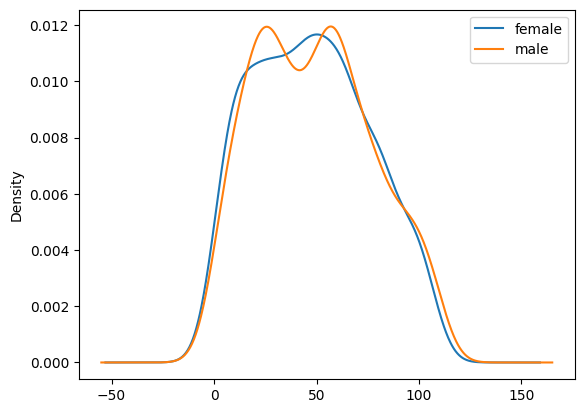

In [66]:
df.groupby('gender').AGE.plot(kind='kde',legend=True)

TYPE2DIABETES

,gender,TYPE2DIABETES_AGE,TYPE2DIABETES,_id,Key
26,male,40,1,28100,Patient/28100
41,male,25,1,33192,Patient/33192
57,female,25,1,44068,Patient/44068
63,male,31,1,48733,Patient/48733
79,male,34,1,56046,Patient/56046
...,...,...,...,...,...
1136,female,25,1,651087,Patient/651087
1146,male,28,1,658997,Patient/658997
1176,female,34,1,673212,Patient/673212
1216,female,42,1,695881,Patient/695881


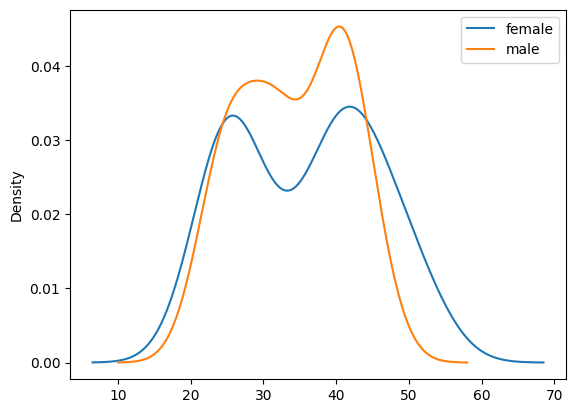

In [67]:
dfDiabetes = df[['gender','TYPE2DIABETES_AGE','TYPE2DIABETES','_id','Key']].query('TYPE2DIABETES == 1')
dfDiabetes.groupby('gender').TYPE2DIABETES_AGE.plot(kind='kde',legend=True)

dfDiabetes

,gender,OBESE_AGE,OBESE,_id,Key
0,male,40.0,1,4,Patient/4
2,male,37.0,1,2,Patient/2
3,female,35.0,1,31,Patient/31
7,male,37.0,1,22901,Patient/22901
10,female,25.0,1,23343,Patient/23343
...,...,...,...,...,...
1219,female,44.0,1,697255,Patient/697255
1221,female,42.0,1,698268,Patient/698268
1222,female,28.0,1,698921,Patient/698921
1223,male,40.0,1,699103,Patient/699103


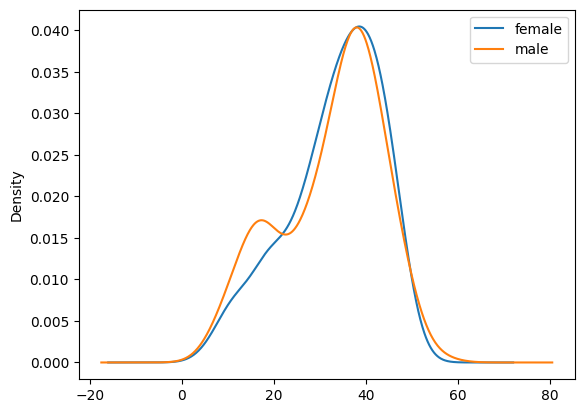

In [68]:
dfDiabetes = df[['gender','OBESE_AGE','OBESE','_id','Key']].query('OBESE == 1')
dfDiabetes.groupby('gender').OBESE_AGE.plot(kind='kde',legend=True)

dfDiabetes

We are missing ethnic, race and birth sex from our dataset. This includes a concept in FHIR called FHIRPath and this is demonstrated in another workbook.


In [69]:
sql = """
      select patient._id, patient.KEY, DATEDIFF('year',birthdate,$HOROLOG) as AGE,
             gender,
             case gender
                 when 'male' then 1
                 when 'female' then 2
                 when 'other' then 0
                 else 9
                 end as genderUK,
             IFNULL(diabetes._id,0,1) as TYPE2DIABETES,
             IFNULL(hypertension._id,0,1) as HYPERTENSION,
             IFNULL(obese._id,0,1) as OBESE,
             IFNULL(veryobese._id,0,1) as VERY_OBESE,
             IFNULL(diabetes._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(diabetes.onsetDateStart,'YYYY-MM-DD'))) as TYPE2DIABETES_AGE,
             IFNULL(hypertension._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(hypertension.onsetDateStart,'YYYY-MM-DD'))) as HYPERTENSION_AGE,
             IFNULL(obese._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(obese.onsetDateStart,'YYYY-MM-DD'))) as OBESE_AGE,
             IFNULL(veryobese._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(veryobese.onsetDateStart,'YYYY-MM-DD'))) as VERY_OBESE_AGE
              , GetFHIRPathOne(ResourceString, 'Patient.extension(''http://hl7.org/fhir/us/core/StructureDefinition/us-core-race'').extension(''ombCategory'').valueCoding.display','Patient') Race
              , GetFHIRPathOne(ResourceString, 'Patient.extension(''http://hl7.org/fhir/us/core/StructureDefinition/us-core-race'').extension(''ombCategory'').valueCoding.code','Patient') RaceCode
              , GetFHIRPathOne(ResourceString, 'Patient.extension(''http://hl7.org/fhir/us/core/StructureDefinition/us-core-ethnicity'').extension(''ombCategory'').valueCoding.display','Patient') Ethnic
              , GetFHIRPathOne(ResourceString, 'Patient.extension(''http://hl7.org/fhir/us/core/StructureDefinition/us-core-ethnicity'').extension(''ombCategory'').valueCoding.code','Patient') EthnicCode
              , GetFHIRPathOne(ResourceString, 'Patient.extension(''http://hl7.org/fhir/us/core/StructureDefinition/us-core-birthsex'').valueCode', 'Patient') BirthSex

      from HSFHIR_X0001_S.Patient patient
               join HSFHIR_X0001_R.Rsrc resource on resource.ResourceType = 'Patient' and resource.Key = patient.Key
               left outer join HSFHIR_X0001_S.Condition diabetes on patient.Key = diabetes.patient and diabetes.code [ '44054006'
               left outer join HSFHIR_X0001_S.Condition hypertension on patient.Key = hypertension.patient and hypertension.code [ '59621000'
               left outer join HSFHIR_X0001_S.Condition obese on patient.Key = obese.patient and obese.code [ '162864005'
               left outer join HSFHIR_X0001_S.Condition veryobese on patient.Key = veryobese.patient and veryobese.code [ '408512008'
      """

cursor.execute(sql)
data = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
df = pd.DataFrame(data, columns=column_names)
pd.set_option('future.no_silent_downcasting', True)
df

,_id,Key,AGE,gender,genderUK,TYPE2DIABETES,HYPERTENSION,OBESE,VERY_OBESE,TYPE2DIABETES_AGE,HYPERTENSION_AGE,OBESE_AGE,VERY_OBESE_AGE,Race,RaceCode,Ethnic,EthnicCode,BirthSex
0,2,Patient/2,71,male,1,0,0,1,0,NaN,NaN,37.0,NaN,White,2106-3,Not Hispanic or Latino,2186-5,M
1,3,Patient/3,16,female,2,0,0,0,0,NaN,NaN,NaN,NaN,White,2106-3,Not Hispanic or Latino,2186-5,F
2,4,Patient/4,50,male,1,0,1,1,0,NaN,18.0,40.0,NaN,White,2106-3,Not Hispanic or Latino,2186-5,M
3,31,Patient/31,80,female,2,0,0,1,0,NaN,NaN,35.0,NaN,Asian,2028-9,Not Hispanic or Latino,2186-5,F
4,876,Patient/876,80,female,2,0,0,0,0,NaN,NaN,NaN,NaN,Asian,2028-9,Not Hispanic or Latino,2186-5,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,699103,Patient/699103,40,male,1,0,0,1,0,NaN,NaN,40.0,NaN,White,2106-3,Not Hispanic or Latino,2186-5,M
1224,699656,Patient/699656,25,male,1,0,0,1,0,NaN,NaN,12.0,NaN,White,2106-3,Not Hispanic or Latino,2186-5,M
1225,700081,Patient/700081,6,female,2,0,0,0,0,NaN,NaN,NaN,NaN,White,2106-3,Not Hispanic or Latino,2186-5,F
1226,700420,Patient/700420,76,female,2,0,1,0,0,NaN,18.0,NaN,NaN,Black or African American,2054-5,Not Hispanic or Latino,2186-5,F


In [70]:
dfObesity = df[['Ethnic','Race','gender','genderUK','OBESE_AGE','OBESE','_id','Key']].query('OBESE == 1')

dfObesity

,Ethnic,Race,gender,genderUK,OBESE_AGE,OBESE,_id,Key
0,Not Hispanic or Latino,White,male,1,37.0,1,2,Patient/2
2,Not Hispanic or Latino,White,male,1,40.0,1,4,Patient/4
3,Not Hispanic or Latino,Asian,female,2,35.0,1,31,Patient/31
8,Not Hispanic or Latino,White,male,1,37.0,1,22901,Patient/22901
10,Not Hispanic or Latino,White,female,2,25.0,1,23343,Patient/23343
...,...,...,...,...,...,...,...,...
1219,Hispanic or Latino,Asian,female,2,44.0,1,697255,Patient/697255
1221,Not Hispanic or Latino,White,female,2,42.0,1,698268,Patient/698268
1222,Not Hispanic or Latino,White,female,2,28.0,1,698921,Patient/698921
1223,Not Hispanic or Latino,White,male,1,40.0,1,699103,Patient/699103


Ethnic
Hispanic or Latino        Axes(0.125,0.11;0.775x0.77)
Not Hispanic or Latino    Axes(0.125,0.11;0.775x0.77)
Name: OBESE_AGE, dtype: object

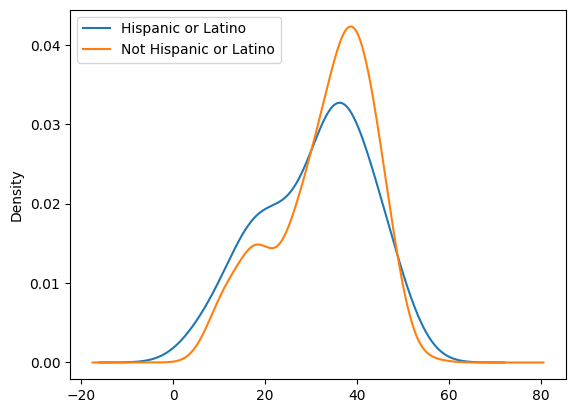

In [71]:
dfObesity.groupby('Ethnic').OBESE_AGE.plot(kind='kde',legend=True)


Race
American Indian or Alaska Native    Axes(0.125,0.11;0.775x0.77)
Asian                               Axes(0.125,0.11;0.775x0.77)
Black or African American           Axes(0.125,0.11;0.775x0.77)
White                               Axes(0.125,0.11;0.775x0.77)
Name: OBESE_AGE, dtype: object

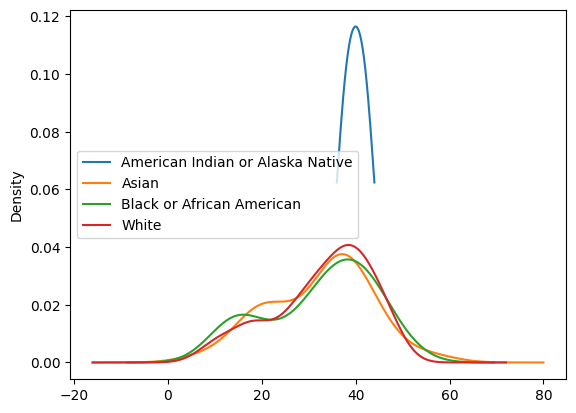

In [72]:
dfObesity.groupby('Race').OBESE_AGE.plot(kind='kde',legend=True)


Data points per race group:
                                  count
Race                                   
American Indian or Alaska Native      1
Asian                                14
Black or African American            24
White                               152


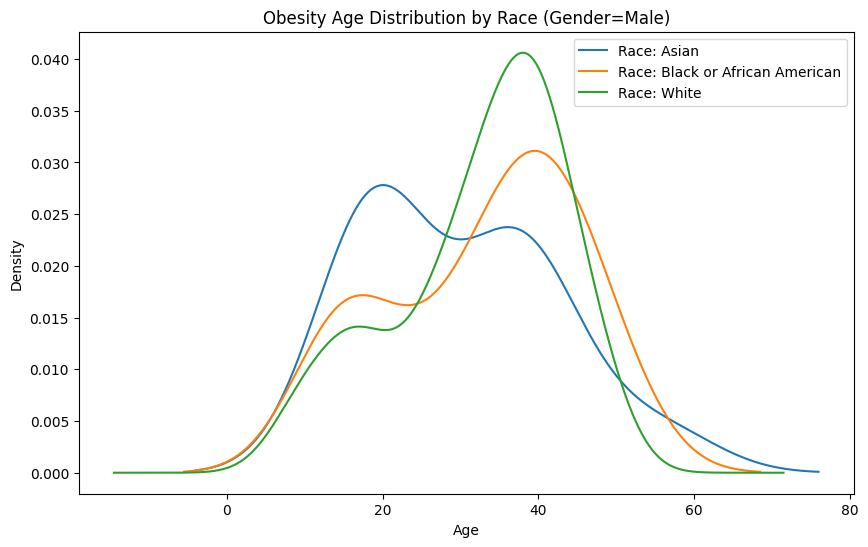

In [73]:
grouped_data = dfObesity.query('genderUK == 1').groupby('Race')['OBESE_AGE'].agg(['count'])
print("Data points per race group:")
print(grouped_data)

# Modified plotting code with error handling
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

for name, group in dfObesity.query('genderUK == 1').groupby('Race'):
    if len(group['OBESE_AGE']) > 1:  # Only plot if we have more than one data point
        group['OBESE_AGE'].plot(kind='kde', ax=ax, label=f'Race: {name}')

plt.title('Obesity Age Distribution by Race (Gender=Male)')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()


Data points per race group:
                                  count
Race                                   
American Indian or Alaska Native      1
Asian                                18
Black or African American            19
White                               152


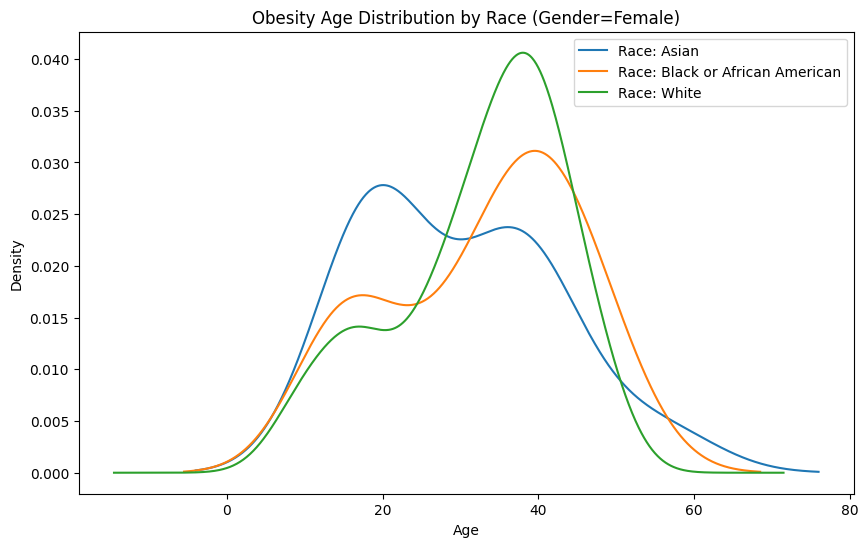

In [74]:
grouped_data = dfObesity.query('genderUK == 2').groupby('Race')['OBESE_AGE'].agg(['count'])
print("Data points per race group:")
print(grouped_data)

# Modified plotting code with error handling
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

for name, group in dfObesity.query('genderUK == 1').groupby('Race'):
    if len(group['OBESE_AGE']) > 1:  # Only plot if we have more than one data point
        group['OBESE_AGE'].plot(kind='kde', ax=ax, label=f'Race: {name}')

plt.title('Obesity Age Distribution by Race (Gender=Female)')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()


In [75]:
dfDiabetes = df[['Ethnic','Race','gender','genderUK','TYPE2DIABETES_AGE','TYPE2DIABETES','_id','Key']].query('TYPE2DIABETES == 1')

Ethnic
Hispanic or Latino        Axes(0.125,0.11;0.775x0.77)
Not Hispanic or Latino    Axes(0.125,0.11;0.775x0.77)
Name: TYPE2DIABETES_AGE, dtype: object

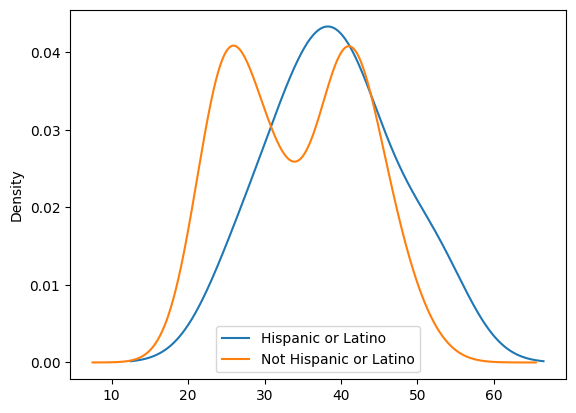

In [76]:
dfDiabetes.groupby('Ethnic').TYPE2DIABETES_AGE.plot(kind='kde',legend=True)

In [77]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

le_race = LabelEncoder()
le_gender = LabelEncoder()

unprocX = df[['EthnicCode','RaceCode','genderUK','AGE', 'HYPERTENSION','OBESE','VERY_OBESE']].copy()

# Transform categorical columns
#X['RaceCode'] = le_race.fit_transform(X['RaceCode'])
#X['genderUKCode'] = le_gender.fit_transform(X['genderUK'])

Y = df.TYPE2DIABETES

The codes in EthnicCode represent Hispanic or Latino, or not. In the next section of code we change this to a 1 or 0.

In [78]:
import numpy as np
unprocX['EthnicCode'] = np.where(unprocX['EthnicCode'] == '2135-2', 1, 0)

unprocX = unprocX.rename(columns={'EthnicCode': 'LatinoHispanic'})

# check column has been renamed
list(unprocX)


['LatinoHispanic',
 'RaceCode',
 'genderUK',
 'AGE',
 'HYPERTENSION',
 'OBESE',
 'VERY_OBESE']

In [79]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(unprocX[['RaceCode', 'genderUK']])

one_hot_df = pd.DataFrame(one_hot_encoded,
                          columns=encoder.get_feature_names_out(['RaceCode', 'genderUK']))

X = pd.concat([unprocX, one_hot_df], axis=1)

X = X.drop(['RaceCode', 'genderUK'], axis=1)

X = X.rename(columns={'RaceCode_1002-5': 'AmericanIndianOrAlaskaNative', 'RaceCode_2054-5':'BlackOrAfricanAmerican','RaceCode_2106-3':'White', 'RaceCode_2028-9':'Asian' })

X = X.rename(columns={'genderUK_1':"Male",'genderUK_2':'Female' })
list(X)
#df_encoded

['LatinoHispanic',
 'AGE',
 'HYPERTENSION',
 'OBESE',
 'VERY_OBESE',
 'AmericanIndianOrAlaskaNative',
 'Asian',
 'BlackOrAfricanAmerican',
 'White',
 'RaceCode_UNK',
 'RaceCode_None',
 'Male',
 'Female']

Run decision tree ML

In [80]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X,Y)

DecisionTreeClassifier(max_depth=5)

Render using dtreeviz

In [83]:
import dtreeviz

viz_model = dtreeviz.model(dt,
                           X_train=X, y_train=Y,
                           feature_names=X.columns,
                           target_name='Diabetes',
                           class_names=['No Diabetes', 'Diabetes'])

viz_model.view()

C:\Development\MFT\notebook-examples\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with ad

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

Maybe remove - this works in intelij and dtreeviz doesn't

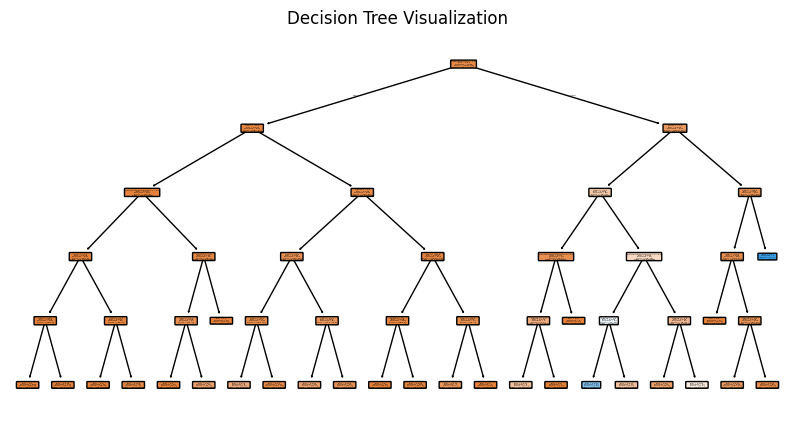

In [84]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Assuming you have your decision tree model 'dt', and data X, Y
plt.figure(figsize=(10,5))
plot_tree(dt, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'],
          filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


In [17]:
conn.close()
conn

In [ ]:
cursor.isClosed()
cursor